# Определение возраста покупателей

В данном проекте я разрабатываю систему, которая должна определять возраст покупателя по фото

## Исследовательский анализ данных

In [1]:
#Импорт необходимых компонентов
import pandas as pd

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Загружаю данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(labels)

       file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
print(labels.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


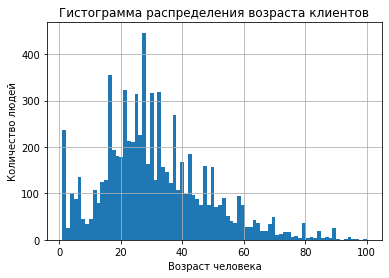

In [6]:
labels.hist(bins = 80)
plt.xlabel('Возраст человека')
plt.ylabel('Количество людей')
 
plt.title('Гистограмма распределения возраста клиентов')
 
plt.show()

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


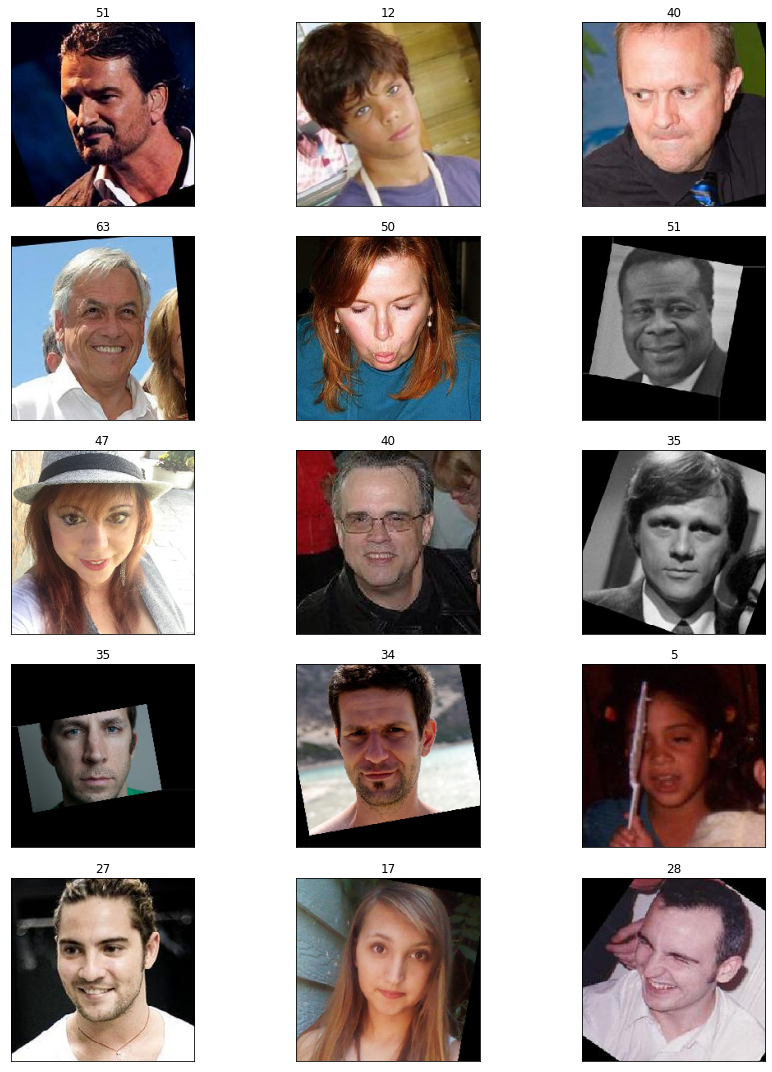

In [9]:
#Вывожу фото
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Наблюдения: Мне было предоставленно 7.5 тыс. фотографий. Их возраст людей на большей части фотографий находится в диапазоне 20-41 лет.

Фотографии достаточно сильно отличаются друг от друга, люди на них принадлежат к разным этносам, их головы могут как смотреть на камеру, так и быть повёрнуты на 90 градусов, качество фото также различается

Также стоит отметить присутсвие черно-белых и слегка повёрнутых фотографий, кроме того, тут присутсвуют фотографии, на которых лицо частитчно прикрыто посторонними объектами.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset = 'training')
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.25)
    train_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset = 'validation')
    
    return train_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='relu'))
    optimizer=Adam(lr=0.0001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-05-27 18:11:31.740437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-27 18:11:32.592661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 79s - loss: 231.0833 - mae: 10.9006 - val_loss: 857.1296 - val_mae: 24.4025
Epoch 2/10
178/178 - 64s - loss: 74.8531 - mae: 6.5164 - val_loss: 741.1543 - val_mae: 22.2304
Epoch 3/10
178/178 - 64s - loss: 49.3613 - mae: 5.3145 - val_loss: 475.2834 - val_mae: 16.7807
Epoch 4/10
178/178 - 64s - loss: 35.7167 - mae: 4.5862 - val_loss: 114.5203 - val_mae: 8.1101
Epoch 5/10
Epoch 6/10
178/178 - 64s - loss: 28.2185 - mae: 4.0359 - val_loss: 76.5549 - val_mae: 6.5921
178/178 - 43s - loss: 22.1134 - mae: 3.6135 - val_loss: 66.7335 - val_mae: 6.1622
Epoch 7/10
178/178 - 40s - loss: 17.4357 - mae: 3.2132 - val_loss: 76.4486 - val_mae: 6.4407
Epoch 8/10
178/178 - 42s - loss: 15.5735 - mae: 3.0208 - val_loss: 68.5886 - val_mae: 6.1557
Epoch 9/10
178/178 - 40s - loss: 13.2632 - mae: 2.7933 - val_loss: 60.6133 - val_mae: 5.8404
Epoch 10/10
178/178 - 40s - loss: 11.3266 - mae: 2.5526 - val_loss: 64.4707 - val_mae: 6.1217
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 64.4707 - mae: 6.1217
Test MAE: 6.1217

```

## Анализ обученной модели

Обучение было произведенно на архитектуре ResNet 50, количество эпох - 10

Данная модель показала результат в 6 MAE что на 2 ниже грани удовлетворительного результата, задачу проекта считаю выполненой.